<a href="https://colab.research.google.com/github/smayo2/Explore-PhD-Pay/blob/master/phd_stipends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project explores PhD stipends across universities. Dataset can be found in [on the Kaggle website](https://www.kaggle.com/paultimothymooney/phd-stipends/data). The original data is from http://www.phdstipends.com/csv. 

A First Draft...

In [174]:
import pandas as pd
import numpy as np
import io
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

In [175]:
#read data file
file_URL = "https://drive.google.com/file/d/1lp09EJkJJkhKcU_67PSQ27rdunDB4NWK/view?usp=sharing"
data_path = 'https://drive.google.com/uc?export=download&id='+file_URL.split('/')[-2]

df = pd.read_csv(data_path)

Get basic characteristics like size and summary statistics


In [176]:
display(df.head())
display ("Size of Data:", df.shape)
display(df.info())

#not using comments column, so dropping
df.drop(columns = "Comments", inplace=True)

,University,Department,Overall Pay,LW Ratio,Academic Year,Program Year,12 M Gross Pay,9 M Gross Pay,3 M Gross Pay,Fees,Comments
0,University of Tennessee - Knoxville,Economics,"$1,850",0.09,2020-2021,1st,NaN,"$1,850",NaN,NaN,NaN
1,University of Arizona (U of A),Economics,"$21,000",1.01,2020-2021,1st,NaN,"$21,000",NaN,NaN,$10500 per semester. RA/TA required. Need to p...
2,University of Arizona (U of A),Economics,"$19,800",0.96,2020-2021,1st,NaN,"$21,000",NaN,"$1,200",NaN
3,University of Florida,ECE,"$22,600",NaN,2020-2021,1st,"$24,000",NaN,NaN,"$1,400",NaN
4,University of Virginia (UVA),ECE,"$26,000",1.14,2020-2021,1st,"$26,000",NaN,NaN,NaN,NaN


'Size of Data:'

(8707, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8707 entries, 0 to 8706
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   University      8444 non-null   object 
 1   Department      8247 non-null   object 
 2   Overall Pay     8686 non-null   object 
 3   LW Ratio        7796 non-null   float64
 4   Academic Year   8703 non-null   object 
 5   Program Year    7687 non-null   object 
 6   12 M Gross Pay  6209 non-null   object 
 7   9 M Gross Pay   2474 non-null   object 
 8   3 M Gross Pay   798 non-null    object 
 9   Fees            3352 non-null   object 
 10  Comments        2155 non-null   object 
dtypes: float64(1), object(10)
memory usage: 748.4+ KB


None

In [177]:
#helper functions

#get total annual pay: by adding summer pay to 9 months pay, where applicable
def calc_total_income(row):
  twelve_mth_pay = row["12 M Gross Pay"]
  if twelve_mth_pay==0:
    return row["9 M Gross Pay"]+ row["3 M Gross Pay"]
  else: return twelve_mth_pay


From the describe method of the dataframe, we see most columns have many missing values. Also most of the data are in string format. We can address these issues as follows.

In [178]:
#replace null values
df["University"].fillna("Unspecified", inplace = True)
df["Department"].fillna("Unspecified", inplace = True)

#get list of abbreviated departments
#display(df[(df["Department"].apply(len)<5)]["Department"].value_counts().head(3))
df.dropna(subset=["Overall Pay"], inplace=True)

#convert salaries to numeric 
money_columns = ["Overall Pay", "12 M Gross Pay", "9 M Gross Pay",\
                 "3 M Gross Pay", "Fees"] 

df[money_columns] = df[money_columns].apply(lambda x: x.str.replace(",", "")\
                                            .str.replace("$", "")\
                                            .astype("float")) 



In [179]:

#strip away "st", "nd" etc, assuming that program year is single digit
#if year is NaN replace with zero
df["Program Year"].fillna(0, inplace=True)
df["Program Year"] = df["Program Year"].apply(lambda x: str(x)[0])\
                        .astype("int")

#looking at output we see outliers 
df = df[(np.abs(zscore(df["Overall Pay"])) < 3)]

df["Overall Pay"].fillna(df["Overall Pay"].median(), inplace = True) 

#handle NaNs for academic year:very few, so can drop
df.dropna(subset=["Academic Year"], inplace=True)

#consider numeric columns
numeric_columns = df.select_dtypes('number').columns
#Most NaN are in non-applicable fields, so replacing with zero 
df[numeric_columns] = df[numeric_columns].fillna(0) 

#create a column with total 12 month gross income
df["Total Income"] = df.apply(calc_total_income, axis=1)

#set as categorical
cat_columns = df.select_dtypes('object').columns
df[cat_columns] = df[cat_columns].astype('category')

display(df.info())
#df.head() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8649 entries, 0 to 8706
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   University      8649 non-null   category
 1   Department      8649 non-null   category
 2   Overall Pay     8649 non-null   float64 
 3   LW Ratio        8649 non-null   float64 
 4   Academic Year   8649 non-null   category
 5   Program Year    8649 non-null   int64   
 6   12 M Gross Pay  8649 non-null   float64 
 7   9 M Gross Pay   8649 non-null   float64 
 8   3 M Gross Pay   8649 non-null   float64 
 9   Fees            8649 non-null   float64 
 10  Total Income    8649 non-null   float64 
dtypes: category(3), float64(7), int64(1)
memory usage: 775.7 KB


None

In [180]:
#get summary statistics for numeric columns
display(df.describe())

,Overall Pay,LW Ratio,Program Year,12 M Gross Pay,9 M Gross Pay,3 M Gross Pay,Fees,Total Income
count,8649.000000,8649.000000,8649.000000,8649.000000,8649.000000,8649.000000,8649.000000,8649.000000
mean,24539.589664,0.950874,1.801249,19446.599723,5535.731645,464.838710,907.580414,25447.170077
std,9661.409990,0.480941,1.514398,14546.471887,9556.222278,1849.474327,3702.375557,9395.574074
min,-37000.000000,-1.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19007.000000,0.750000,1.000000,0.000000,0.000000,0.000000,0.000000,20000.000000
50%,25000.000000,1.050000,1.000000,24000.000000,0.000000,0.000000,0.000000,25800.000000
75%,30300.000000,1.280000,3.000000,30000.000000,13500.000000,0.000000,700.000000,30800.000000
max,90000.000000,4.500000,6.000000,100000.000000,90000.000000,55816.000000,93725.000000,112000.000000


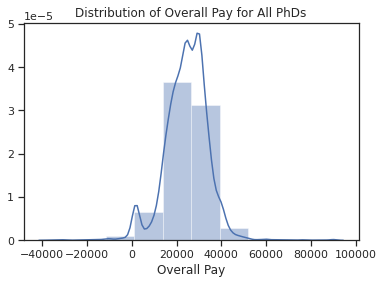

'------------------------------------------\n'

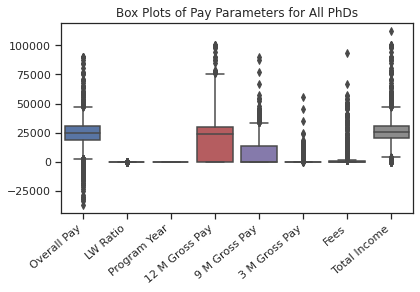

In [181]:
#Visualisations

plot_title = "Distribution of Overall Pay for All PhDs"
ax = sns.distplot(df["Overall Pay"], bins=10)
ax.set_title(plot_title) 
plt.show() 
display("------------------------------------------\n")
plot_title = "Box Plots of Pay Parameters for All PhDs"
ax=sns.boxplot(data=df) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
ax.set_title(plot_title) 
plt.show()

In [182]:

#ignore program year of zero (NaNs)

#top 10 universities for overall pay
display("top 10 universities for median overall pay")
grp_data = df.groupby("University")["Overall Pay"].agg([min, np.median, max])\
        .sort_values(by="median", ascending=False).reset_index().head(10)
display(grp_data)

display(" bottom 10 universities for median overall pay")
grp_data = df.groupby("University")["Overall Pay"].agg([min, np.median, max])\
        .sort_values(by="median", ascending=False).reset_index().tail(10)
display(grp_data)


'top 10 universities for median overall pay'

,University,min,median,max
0,Anna University,84000.0,84000.0,84000.0
1,University of Nebraska - Omaha (UNO),75500.0,75500.0,75500.0
2,ETH,75000.0,75000.0,75000.0
3,Swiss Federal Institute of Technology in Zurich,69500.0,69500.0,69500.0
4,Aarhus University,63700.0,63700.0,63700.0
5,Norwegian University of Science and Technology,51142.0,56071.0,61000.0
6,Technical University of Denmark,56000.0,56000.0,56000.0
7,Ecole Polytechnique Federale de Lausanne,53600.0,53600.0,53600.0
8,Norwegian University of Life Sciences (NMBU),53000.0,53000.0,53000.0
9,Norwegian University of Life Sciences,52000.0,52000.0,52000.0


' bottom 10 universities for median overall pay'

,University,min,median,max
681,King Fahd University of Petroleum and Minerals,237.0,237.0,237.0
682,Scumbag college,8.0,8.0,8.0
683,Northcentral University,-250.0,-250.0,-250.0
684,DePaul University,-4600.0,-4600.0,-4600.0
685,HNGU UNIVERSITY PATAN,-10000.0,-10000.0,-10000.0
686,University of Windsor,-10000.0,-10000.0,-10000.0
687,University of Cambridge,-11129.0,-11129.0,-11129.0
688,Yale,-12000.0,-12000.0,-12000.0
689,Bharathiar,-20000.0,-20000.0,-20000.0
690,nit,-34210.0,-34210.0,-34210.0


In [183]:

display("top 10 departments for median overall pay")
grp_data = df.groupby("Department")["Overall Pay"].agg([min, np.median, max])\
        .sort_values(by="median", ascending=False).reset_index().head(10)
display(grp_data)

display("#bottom 10 departments for median overall pay")
grp_data = df.groupby("Department")["Overall Pay"].agg([min, np.median, max])\
        .sort_values(by="median", ascending=False).reset_index().tail(10)
display(grp_data)

'top 10 departments for median overall pay'

,Department,min,median,max
0,environment,87467.0,87467.0,87467.0
1,civil,84000.0,84000.0,84000.0
2,Applied Math w/focus on Financial Derivatives,75500.0,75500.0,75500.0
3,Department of Clinical Medicine,63700.0,63700.0,63700.0
4,Wind Energy,56000.0,56000.0,56000.0
5,Department of physics and astronomy,56000.0,56000.0,56000.0
6,Doctoral Program Computer Science,53600.0,53600.0,53600.0
7,Engineering Education,52695.0,52695.0,52695.0
8,neurphysiology,52000.0,52000.0,52000.0
9,Doctorate,51200.0,51200.0,51200.0


'#bottom 10 departments for median overall pay'

,Department,min,median,max
2447,Forest and Conservation Sciences,-5000.0,-5000.0,-5000.0
2448,petroleum engineering,-18000.0,-8175.0,1650.0
2449,PH.D,-10000.0,-10000.0,-10000.0
2450,Science and letters,-10000.0,-10000.0,-10000.0
2451,Education /PhD full time (Creativities),-11129.0,-11129.0,-11129.0
2452,Information technology,-12500.0,-12500.0,-12500.0
2453,aeroastro,-15000.0,-15000.0,-15000.0
2454,Life science,-20000.0,-20000.0,-20000.0
2455,Computer,-25000.0,-25000.0,-25000.0
2456,"Chemical, Biological and Environmental Enginee...",-31790.0,-31790.0,-31790.0


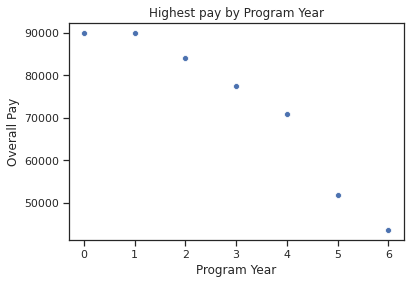

,Program Year,Overall Pay,12 M Gross Pay,9 M Gross Pay,3 M Gross Pay,Fees
0,0,90000.0,90000.0,90000.0,24000.0,50000.0
1,1,90000.0,100000.0,87467.0,55816.0,93725.0
2,2,84000.0,64500.0,67000.0,45000.0,54000.0
3,3,77400.0,100000.0,77400.0,16548.0,40000.0
4,4,71000.0,71000.0,37000.0,35000.0,19000.0
5,5,51900.0,53220.0,37000.0,10000.0,24000.0
6,6,43556.0,43000.0,32868.0,12000.0,36000.0


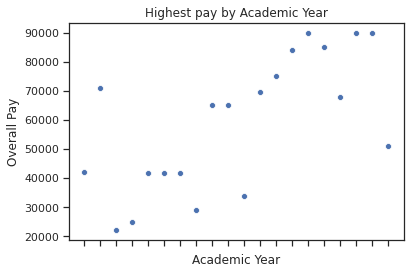

In [184]:

plot_title = "Highest pay by Program Year"
grp_data = df.groupby("Program Year")[money_columns].max().reset_index()
ax = sns.scatterplot(x="Program Year", y="Overall Pay", data=grp_data)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title(plot_title) 
plt.show()
display(grp_data)

plot_title = "Highest pay by Academic Year"
grp_data = df.groupby("Academic Year")[money_columns].max().reset_index()
ax = sns.scatterplot(x="Academic Year", y="Overall Pay", data=grp_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title(plot_title) 
plt.show()

In [185]:
#TODO: some overall pay are negative (mostly because fees exceed pay)
#TODO: clustering

